<a href="https://colab.research.google.com/github/EliasEconomou/DataMining1-Sentiment-Analysis/blob/main/DataMining1_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries and Reading Datafile**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import sys
import os.path
#!pip install --user -U nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
import math
from itertools import chain
import matplotlib.pyplot as plt
from datetime import datetime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Options
pd.options.mode.chained_assignment = None

In [3]:
# Reading data file
fileExists = os.path.exists("./drive/MyDrive/ColabNotebooks/eclass_all_with_sentiment_v2.pkl")
if fileExists:
  DF = pd.read_pickle("./drive/MyDrive/ColabNotebooks/eclass_all_with_sentiment_v2.pkl")
else:
  print('Enter data file path:')
  filePath = input()
  DF = pd.read_pickle(filePath)


# **Preprocessing and Cleaning Data**

In [4]:
# Choose a subset of the dataset's tweets
numOfRows = DF.shape[0]
percentage = 10
df = DF.iloc[:int(percentage*0.01*numOfRows)]
print("Chosen number of tweets is {}.".format(df.shape[0]))

Chosen number of tweets is 22820.


In [5]:
# Remove punctuation, links, hashtags, new lines etc, using regular expressions
df["text"] = df["text"].replace('\.|,|\?|!|:|\(|\)|%|\$','', regex=True)
df["text"] = df["text"].replace('\n|\t','', regex=True)
df["text"] = df["text"].replace(r'(http\S+)|(www\S+)|(#\S+)|(&\S+)|(@\S+)','', regex=True)
df["text"] = df["text"].replace('(\s-\s)','', regex=True)

# Remove emojis by encoding - decoding into ascii, resulting in ignoring emojis
df["text"] = df["text"].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

# Convert text to lowercase
df["text"] = df["text"].str.lower()

# Remove stopwords like 'i','is','you', etc
stopWords = list(stopwords.words('english'))
stopWords.remove("why")
stopWords.remove("how")
stopWords.remove("against")
stopWords.remove("again")
stopWords.remove("not")
stopWords.append("'ve")
stopWords.append("'re")
stopWords.append("'s")
stopWords.append("``")
stopWords.append("''")

# if "'d" in stopWords:
#   print(True)
# else:
#   print(False)
df["text"] = df["text"].apply(word_tokenize)
df["text"] = df["text"].apply(lambda words: [word for word in words if word not in stopWords])

# Remove any unnecessary spaces
df["text"] = df["text"].replace(' +', ' ', regex=True)

# Remove rows with empty data
df.text.dropna()


0        [folks, said, daikon, paste, could, treat, cyt...
1        [world, wrong, side, history, year, hopefully,...
2            [russian, vaccine, created, last, 2-4, years]
3        [facts, immutable, senator, even, not, ethical...
4                     [explain, again, why, need, vaccine]
                               ...                        
22815    [canada, not, approved, sputnik, v, why, not, ...
22816    [breaking, phase, 3, clinical, trials, results...
22817       [breaking, phase, 3, clinical, trials, result]
22818    [view, corruption, exhibited, hide, doping, at...
22819    [central, lazio, region, includes, capital, as...
Name: text, Length: 22820, dtype: object

In [6]:
df["sentiment"]

0        NEU
1        NEG
2        NEU
3        NEU
4        NEG
        ... 
22815    NEU
22816    NEU
22817    NEU
22818    NEG
22819    NEU
Name: sentiment, Length: 22820, dtype: object

# **Analyzing Data**

**0.   Functions**

In [48]:
# Counts the appearances of sentiments in a dictionary, then plots a pie
def plot_sentiments(dataframe):
  sentimentDict = {'POS' : 0, 'NEG' : 0, 'NEU' : 0}
  for sentiment in dataframe["sentiment"]:
    sentimentDict[sentiment] += 1

  labels = sentimentDict.keys()
  sizes = sentimentDict.values()
  explode = [0, 0, 0.07]

  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
          shadow=True, startangle=-25)
  ax1.axis('equal')
  plt.title(label="Distribution of sentiments",
            loc="left",
            pad='20.0',
            backgroundcolor='lime')
  plt.show()

**1.   Distribution of sentiments**

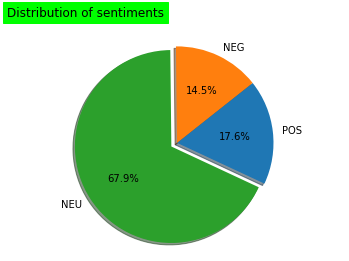

In [49]:
plot_sentiments(df)


**2.   Most used words**

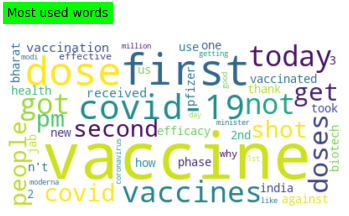

In [8]:
# Plot a wordcloud for most used words in dataset
wordList = list(chain.from_iterable(list(df["text"])))
fdist = FreqDist(wordList)
#print(fdist.most_common(50))

wordcloud = WordCloud(max_words=50,
                      background_color='white',
                      contour_color='black',
                      contour_width=4).generate_from_frequencies(fdist)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(label='Most used words',
          loc="left",
          pad='25.0',
          backgroundcolor='lime')
plt.show()

**3.   Most used words by tweet sentiment**

In [9]:
# Group by sentiment and plot wordclouds for most used words in every sentiment
groupBySent = df.groupby('sentiment')


In [10]:
POSgroup = groupBySent.get_group('POS')
NEGgroup = groupBySent.get_group('NEG')
NEUgroup = groupBySent.get_group('NEU')

In [11]:
POSList = list(chain.from_iterable(list(POSgroup["text"])))
POSfdist = FreqDist(POSList)
NEGList = list(chain.from_iterable(list(NEGgroup["text"])))
NEGfdist = FreqDist(NEGList)
NEUList = list(chain.from_iterable(list(NEUgroup["text"])))
NEUfdist = FreqDist(NEUList)

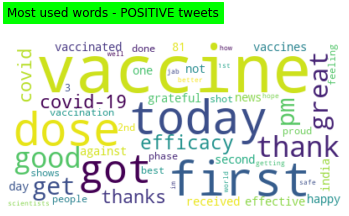

In [12]:
POScloud = WordCloud(max_words=50,
                      background_color='white',
                      contour_color='black',
                      contour_width=4).generate_from_frequencies(POSfdist)

plt.imshow(POScloud, interpolation='bilinear')
plt.axis('off')
plt.title(label='Most used words - POSITIVE tweets',
          loc="left",
          pad='25.0',
          backgroundcolor='lime')
plt.show()

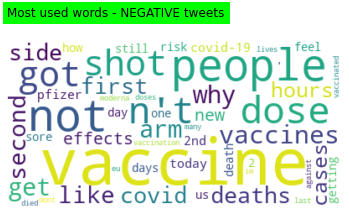

In [13]:
NEGcloud = WordCloud(max_words=50,
                      background_color='white',
                      contour_color='black',
                      contour_width=4).generate_from_frequencies(NEGfdist)

plt.imshow(NEGcloud, interpolation='bilinear')
plt.axis('off')
plt.title(label='Most used words - NEGATIVE tweets',
          loc="left",
          pad='25.0',
          backgroundcolor='lime')
plt.show()

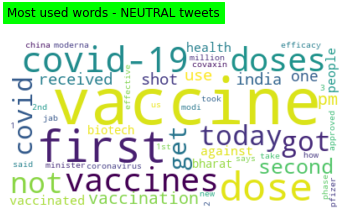

In [14]:
NEUcloud = WordCloud(max_words=50,
                      background_color='white',
                      contour_color='black',
                      contour_width=4).generate_from_frequencies(NEUfdist)

plt.imshow(NEUcloud, interpolation='bilinear')
plt.axis('off')
plt.title(label='Most used words - NEUTRAL tweets',
          loc="left",
          pad='25.0',
          backgroundcolor='lime')
plt.show()

**4.   Sentiment by vaccine**

In [15]:
# Convert hashtags to lowercase
df["hashtags"] = df["hashtags"].str.lower()

# fill with tweets of 'astrazeneca' reference
df1 = pd.DataFrame(columns=df.columns)
# fill with tweets of 'pfizer'/'biontech'/'moderna' reference
df2 = pd.DataFrame(columns=df.columns)

# Iterate all rows of dataframe
for row in df.loc[0:df.shape[0], ['text', 'hashtags']].iterrows():
  
  # if no hashtag exists, check if the words exist in text
  if type(row[1][1])==float:
    if "astrazeneca" in row[1][0]:
      df1 = df1.append(df.iloc[[row[0]]],ignore_index = True)
    if "moderna" or "pfizer" or "biontech" or "pfizerbiontech" in row[1][0]:
      df2 = df2.append(df.iloc[[row[0]]],ignore_index = True)
  
  #else search word in hashtag and text
  else:
    if re.search("astrazeneca", row[1][1]) or "astrazeneca" in row[1][0]:
      df1 = df1.append(df.iloc[[row[0]]],ignore_index = True)
    if re.search("moderna|pfizer|biontech", row[1][1]) or ("moderna" or "pfizer" or "biontech" or "pfizerbiontech" in row[1][0]):
      df2 = df2.append(df.iloc[[row[0]]],ignore_index = True)


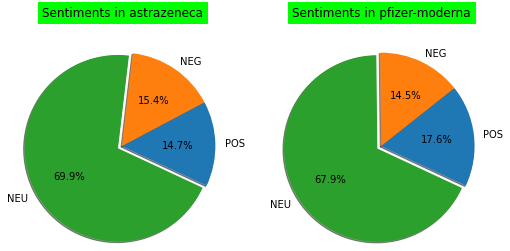

In [16]:
# Count the appearances of sentiments in a dictionary in each df
sentimentDict1 = {'POS' : 0, 'NEG' : 0, 'NEU' : 0}
for sentiment in df1["sentiment"]:
  sentimentDict1[sentiment] += 1

sentimentDict2 = {'POS' : 0, 'NEG' : 0, 'NEU' : 0}
for sentiment in df2["sentiment"]:
  sentimentDict2[sentiment] += 1

labels1 = sentimentDict1.keys()
sizes1 = sentimentDict1.values()
labels2 = sentimentDict2.keys()
sizes2 = sentimentDict2.values()
explode = [0, 0, 0.09]

fig = plt.figure()

ax1 = fig.add_axes([0, .2, .3, .5], aspect=1)
ax1.pie(sizes1, labels=labels1, radius = 1.8, autopct='%1.1f%%',
        shadow=True, startangle=-25, explode=explode)
ax2 = fig.add_axes([.6, .2, .3, .5], aspect=1)
ax2.pie(sizes2, labels=labels2, radius = 1.8, autopct='%1.1f%%',
        shadow=True, startangle=-25, explode=explode)
ax1.set_title(label="Sentiments in astrazeneca",
          pad='65.0',
          backgroundcolor='lime')
ax2.set_title(label="Sentiments in pfizer-moderna",
          pad='65.0',
          backgroundcolor='lime')
plt.show()


**5.   Tweets per month - Important dates**

In [17]:
dateDf = df.copy()

# Grouping by month
dateDf.index = pd.to_datetime(dateDf['date'],format='%Y-%m-%d %H:%M:%S')
groupMonth = dateDf.groupby(pd.Grouper(freq='m'))

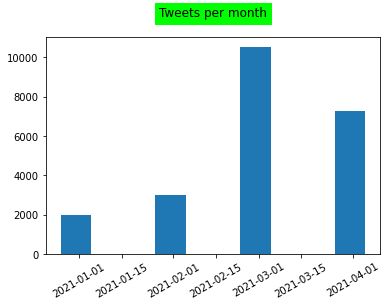

In [18]:
x = groupMonth.size().keys()
y = groupMonth.size()

plt.title(label="Tweets per month",
          pad='20.0',
          backgroundcolor='lime')
plt.bar(x, y, width = 10)
plt.xticks(rotation=30)

plt.show()


We can see more than 10000 people tweeted by the end of February 2021 till March, probably because around that time the FDA granted emergency use authorization to Johnson & Johnson's Covid-19 vaccine, the first single dose Covid-19 vaccine available in the US. The death toll from Covid-19 exceeded 500.000 at that time in the US, while globally deaths reached 3 million.


**6.   Sentiment of popular users**

In [44]:
pd.set_option('display.max_rows', None)
popDf = df[df['user_followers'] > 500000]

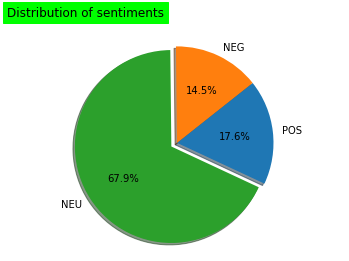

In [47]:
plot_sentiments(popDf)